In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import torch
import imageio
import io
import matplotlib.pyplot as plt
#imageio.plugins.ffmpeg.download()
from simulation_and_reconstruction import *

/gpfs/share/apps/anaconda3/gpu/5.2.0/lib/python3.6/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [5]:
with open("../sample/51925-52494.mkv", "rb") as file:
    content = file.read()

In [6]:
vid = imageio.get_reader(io.BytesIO(content),  'ffmpeg')

In [7]:
metadata = vid.get_meta_data()                                                             

print(metadata)

{'plugin': 'ffmpeg', 'nframes': 570, 'ffmpeg_version': 'N-86111-ga441aa90e8-static http://johnvansickle.com/ffmpeg/ built with gcc 5.4.1 (Debian 5.4.1-8) 20170304', 'fps': 29.97, 'source_size': (3840, 2160), 'size': (3840, 2160), 'duration': 19.02}


In [8]:
len(vid)/metadata['fps']

19.01901901901902

In [9]:
framelist = []
for num, image in enumerate(vid.iter_data()): 
    framelist.append(image)
    #print(image.shape)
    #print(image.mean())
print(len(framelist))

570


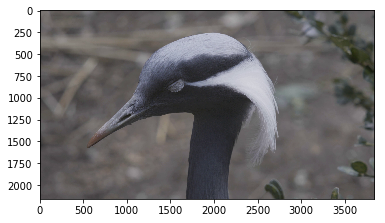

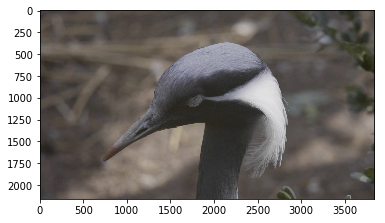

In [10]:
plt.imshow(framelist[150])
plt.show()

plt.imshow(framelist[400])
plt.show()

In [11]:
selected = []
for i in range(150, 400, 10):
    selected.append(np.sum(framelist[i], axis= 2) [:, (3840 -2160) // 2 : (3840 -2160) // 2 + 2160 ]/ (3.0 * 255.0))

varray = np.array(selected)
#varray = np.transpose(varray, (2, 0, 1)) # [frame, x, y]

(25, 2160, 2160)


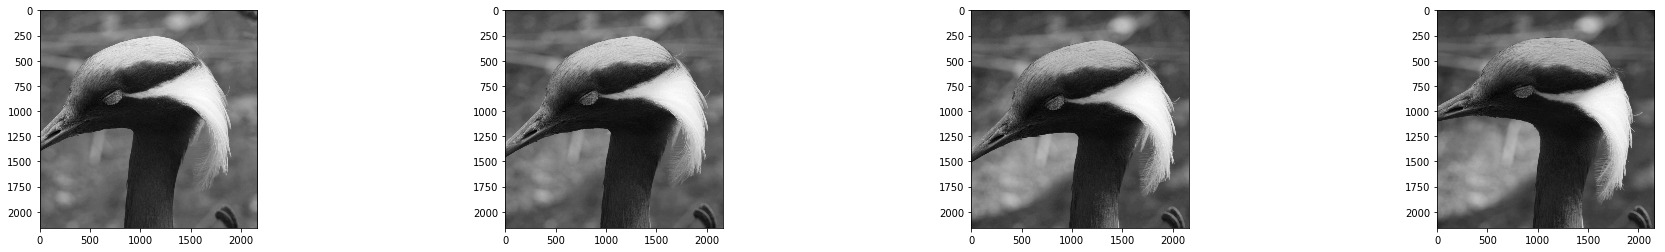

In [12]:
print(varray.shape)
plotcoil(varray[::6], n = 4)

In [13]:
# Initializing value of x-axis and y-axis
# in the range -2 to +2
x, y = np.meshgrid(np.linspace(-2,2,15), np.linspace(-2,2,15))
dst = np.sqrt(x*x+y*y)
  
# Intializing sigma and muu
sigma = 1
muu = 0.000
  
# Calculating Gaussian array
gauss = np.exp(-( (dst-muu)**2 / ( 2.0 * sigma**2 ) ) )
  
#print("2D Gaussian array :\n")
#print(gauss)

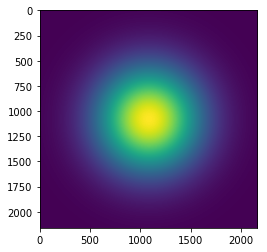

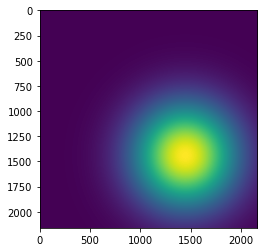

-2.7159614334440985 -2.4297362205984614
-0.2931856863848097 -1.3467973134437867
2.772347649334618 2.320116520047841
-2.657303398799331 2.902808747270443
-2.992691128225254 -0.5880403742186595
-2.1574610131784473 -1.0809250166130033
-1.86285533881983 -2.875495823391939
2.604489942139467 -0.9181195346804172
1.734850601542238 -0.3738761562625035
-0.7086184203761876 1.89269932862548
-0.04282873393952347 -0.011778500781934209
-2.3461652777230797 -2.3717732977698045
-2.951755868003596 1.2208728257035455
-2.3352756694862205 -2.3559333654121533
-1.4087590264573253 1.0978270745054175
0.501748996439412 -0.38070195265067674


In [29]:
def coil_smap_sim(h, w, x0 = 0, y0 = 0):
    #https://www.geeksforgeeks.org/how-to-generate-2-d-gaussian-array-using-numpy/
    # Initializing value of x-axis and y-axis
    # in the range -2 to +2
    x, y = np.meshgrid(np.linspace(-3, 3, h), np.linspace(-3, 3, w))
    dst = np.sqrt(x**2 + y**2)

    # Intializing sigma and muu
    sigma_x, sigma_y = 1.0, h / w

    # Calculating Gaussian array
    gauss = np.exp(-( (x - x0)**2 / ( 2.0 * sigma_x**2 ) \
                    + (y - y0)**2 / ( 2.0 * sigma_y**2 ) ) )
    
    return gauss

def multi_coil_smap_sim(h, w, ncoil = 16):
    res = []
    for i in range(ncoil):
        x0, y0 = np.random.uniform(-3, 3, size = 2)
        print(x0, y0)
        res.append(coil_smap_sim(h, w, x0, y0))
        
    return np.array(res)

gauss = coil_smap_sim(2160, 2160)

plt.imshow(gauss)
plt.show()

gauss = coil_smap_sim(2160, 2160, 1, 1)

plt.imshow(gauss)
plt.show()

smap = multi_coil_smap_sim(2160, 2160, ncoil = 16)

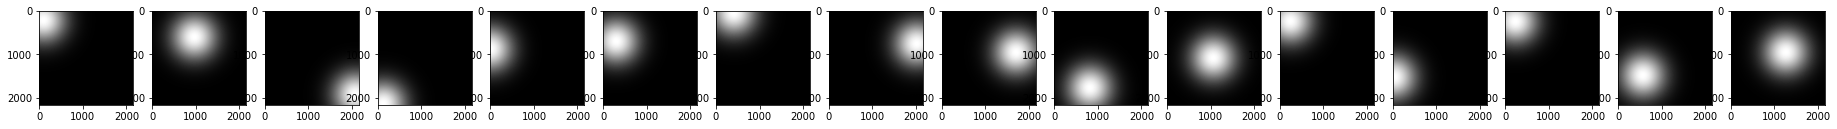

In [30]:
plotcoil(x = smap, n = 16)

In [32]:
smap.shape, varray.shape

((16, 2160, 2160), (25, 2160, 2160))

In [33]:
target = np.repeat(np.expand_dims(varray, axis=0), repeats=2, axis= 0).swapaxes(0, 1) / np.sqrt(2.0)
print(target.shape)

smap = np.expand_dims(np.repeat(np.expand_dims(smap, axis=0), repeats=2, axis= 0).swapaxes(0, 1), 0) / np.sqrt(2.0)
print(smap.shape)

(25, 2, 2160, 2160)
(1, 16, 2, 2160, 2160)


#device = torch.device("cuda")
device = torch.device("cpu")
kspace, recon, traj, dcomp_fs = RadialSimulation(target= torch.tensor(target, dtype = torch.float32).to(device), 
                                                 spokespertime= 21, nt= 25, nc = 16, spokelength= 13, 
                                                 smap= torch.tensor(smap, dtype = torch.float32).to(device), 
                                                 grid_size= (640, 640), im_size= (2160, 2160))

In [ ]:
#device = torch.device("cuda")
device = torch.device("cpu")
kspace, recon, traj, dcomp_fs = RadialSimulation(target= torch.tensor(target, dtype = torch.float32).to(device), 
                                                 spokespertime= 13, nt= 25, nc = 16, spokelength= 640, 
                                                 smap= torch.tensor(smap, dtype = torch.float32).to(device), 
                                                 grid_size= (2160, 2160), im_size= (2160, 2160))

torch.Size([25, 16, 2, 8320])


In [34]:
#device = torch.device("cuda")
device = torch.device("cpu")
kspace, recon, traj, dcomp_fs = RadialSimulation(target= torch.tensor(target[::3], dtype = torch.float32).to(device), 
                                                 spokespertime= 34, nt= 9, nc = 16, spokelength= 640, 
                                                 smap= torch.tensor(smap, dtype = torch.float32).to(device), 
                                                 grid_size= (2160, 2160), im_size= (2160, 2160))

torch.Size([9, 16, 2, 21760])
torch.Size([9, 16, 2, 21760])
torch.Size([9, 2, 2160, 2160])


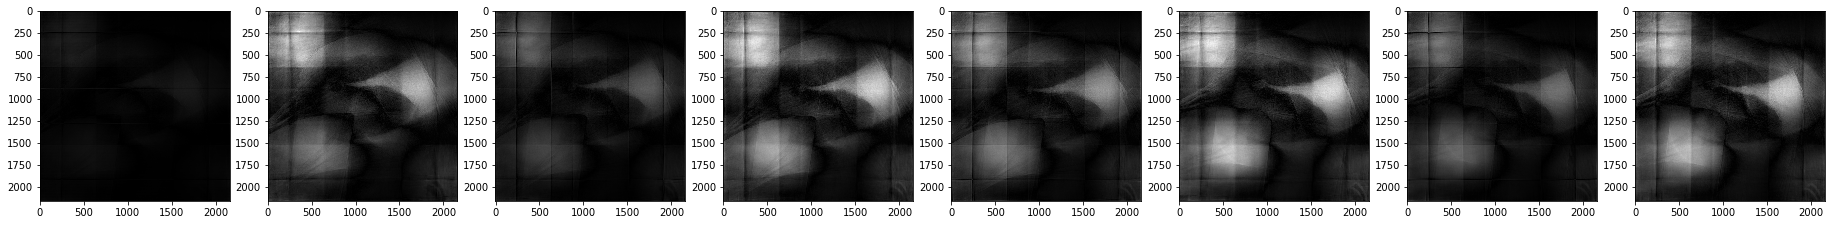

In [35]:
plotcoil(torch.sqrt(recon[:, 0]**2 + recon[:, 1]**2))

In [27]:
21760 / 640

34.0

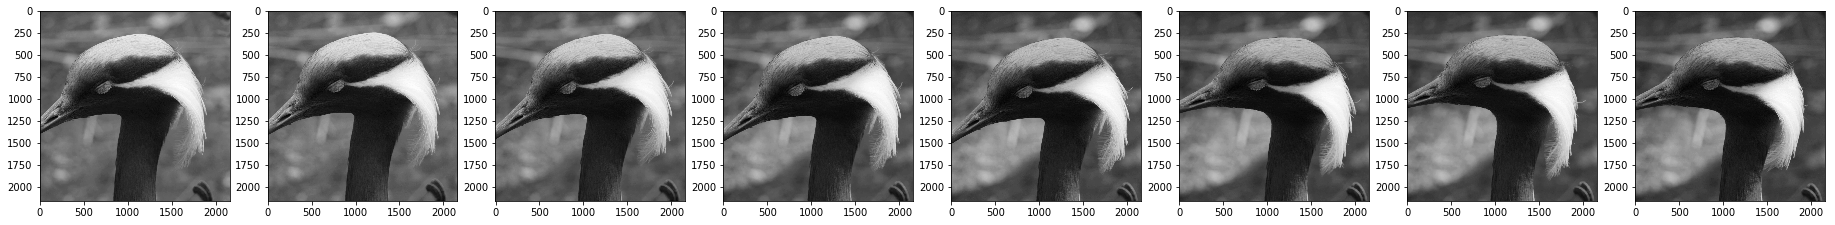

In [28]:
plotcoil(varray[::3])